# Calibrated Explanations for Regression
## Demonstrated on the Californa Housing data set

Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
Sources:
1. [California Housing data set [kaggle]](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

### 1. Import packages, data and train an underlying model

#### 1.1 Import packages

In the examples below, we will be using `NumPy`, `pandas`, `sklearn`, and `crepes`. From `crepes`, we import `ConformalPredictiveSystem` and some helper functions from `crepes.extras`. `CalibratedExplainer` is imported from `calibrated_explanations`.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from calibrated_explanations import CalibratedExplainer

from crepes import ConformalPredictiveSystem
from crepes.extras import DifficultyEstimator

#### 1.2 Import data and train a model
Let us import the Califronia Housing data set (see sources at the top).

In [11]:

dataSet = 'housing.csv'
delimiter = ';'
categorical_labels = {8: {0: 'INLAND', 1: 'NEAR BAY', 2: '<1H OCEAN', 3: 'NEAR OCEAN', 4: 'ISLAND'}}

fileName = '../data/reg/' + dataSet
df = pd.read_csv(fileName, delimiter=delimiter, dtype=np.float64)
target = 'median_house_value'
df.dropna(inplace=True)
X, y = df.drop(target,axis=1), df[target] 
feature_names = df.drop(target,axis=1).columns
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,1.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,1.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,1.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,1.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,1.0


Let us split the data set into a training and a test set, and further split the training set into a proper training set and a calibration set. Let us fit a random forest to the proper training set. We also set a random seed to be able to rerun the notebook and get the same results.

In [12]:
num_to_test = 1

trainCalX, testX, trainCalY, testY = train_test_split(X.values, y.values, test_size=num_to_test, random_state=42)
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33, random_state=42)

model = RandomForestRegressor(n_estimators=100, oob_score=True)

model.fit(trainX,trainY)  

len(trainX), len(calX), len(testX)

(13689, 6743, 1)

Before extracting an explanation, lets see what the output from a Conformal Predictive System (cps) is for the test instance(s). Three use cases are explored:
1. using percentiles to get the lower and upper bounds of an interval.
2. using the 50th percentile(s) to get the median prediction which can be used as a calibrated prediction from the underlying model.
3. getting the probability of the prediction being below a certain threshold. 250 000 is used as threshold, as it is close to the midpoint in the possible range of prices.

In [13]:
calY_pred = model.predict(calX)
testY_pred = model.predict(testX)

cps = ConformalPredictiveSystem()
cps.fit(residuals=calY-calY_pred)

interval = cps.predict(y_hat=testY_pred, lower_percentiles=[5,50], higher_percentiles=[95,50])

p_values = cps.predict(y_hat=testY_pred, y=250000)

print('5th percentile, prediction, 50th percentile, 95th percentile, true value, p-value (cpsd<250000)')
print(*zip(np.round(interval[:,0], decimals=1), 
           np.round(testY_pred, decimals=1), 
           np.round((interval[:,1] + interval[:,3])/2, decimals=1), 
           np.round(interval[:,2], decimals=1), 
           np.round(testY,decimals=1), 
           np.round(p_values*100, decimals=1)),sep='\n')  

5th percentile, prediction, 50th percentile, 95th percentile, true value, p-value (cpsd<250000)
(147220.0, 215188.0, 209538.0, 297820.0, 245800.0, 85.5)


Create the `CalibratedExplainer` by feeding the model, the calibration set, and mode='regression' as a minimum. 

In [14]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY, 
                        feature_names=feature_names, 
                        categorical_labels=categorical_labels,
                        mode='regression')  
display(ce)

CalibratedExplainer:
	                mode=regression
	                discretizer=<class 'calibrated_explanations._discretizers.BinaryDiscretizer'>
	                model=RandomForestRegressor(oob_score=True)

In the examples below, all intervals will be with 95% certainty and can be either two-sided or one-sided. The intervals are defined by assigning a pair of values to the `low_high_percentiles` attribute (see below).

In [15]:
tsi = (2.5,97.5) # two-sided interval with 95% confidence
osli = (5,np.inf) # one-sided lower-bounded interval with 95% confidence
osui = (-np.inf,95) # one-sided upper-bounded interval with 95% confidence

#### Two-sided interval with 95% confidence
When using regular or uncertainty plots, the recommended (and for regression default) `Discretizer` is the `BinaryDiscretizer`. As no discretizer was assigned at initialization, it is already assigned `BinaryDiscretizer`. 

Since we are defining two-sided intervals, `low_high_percentiles=tsi`.

Once the explanations are extracted, we can visualize them using various plots. The regular plot include an uncertainty estimate for the prediction and the weights of the most influential features. The shaded area is the the prediction interval with 95% confidence. The solid line in the middle of the shaded interval is the median in the conformal predictive distribution.

Regular plots are shown by calling the function `plot_regular`, with `n_features_to_show` indicating the number of features to include, in order of importance. To save the plots to disk, `save_ext` can take one or several of the following extensions `['pdf','svg','png']` creating a plot for each instance and file format. 

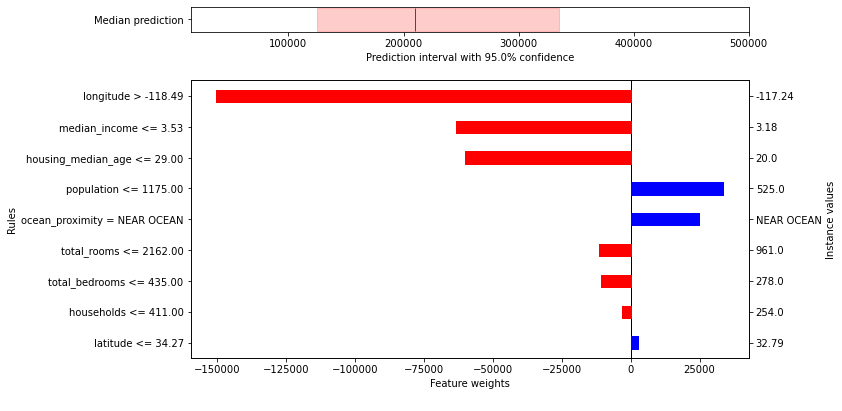

In [16]:
exp = ce.get_factuals(testX, low_high_percentiles=tsi)
exp.plot_regular(n_features_to_show=10, save_ext=[])

Uncertainty plots are similar to regular plots but also provide an uncertainty estimate for the impact of each feature. Here, the shaded area is the range of possible changes with the assigned confidence interval (here a two-sided interval with 95% confidence, as defined above). The solid line in the midle of the shaded interval is the median in the conformal predictive distribution.

To get uncertainty plots, the `plot_uncertainty` function can be called with the same parameters as `plot_regular`.

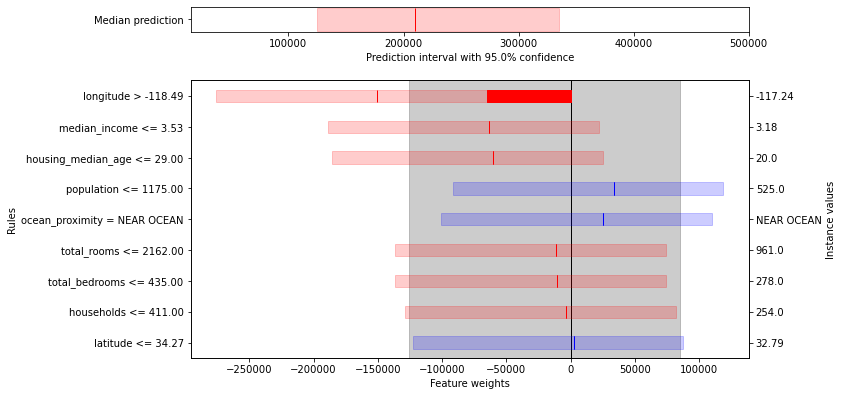

In [17]:
exp.plot_uncertainty(n_features_to_show=10, save_ext=[])

#### One-sided lower-bounded interval with 95% confidence
To change confidence or interval type, new explanations must be extracted. Here `low_high_percentiles=osli` to get a one-sided lower-bounded interval.

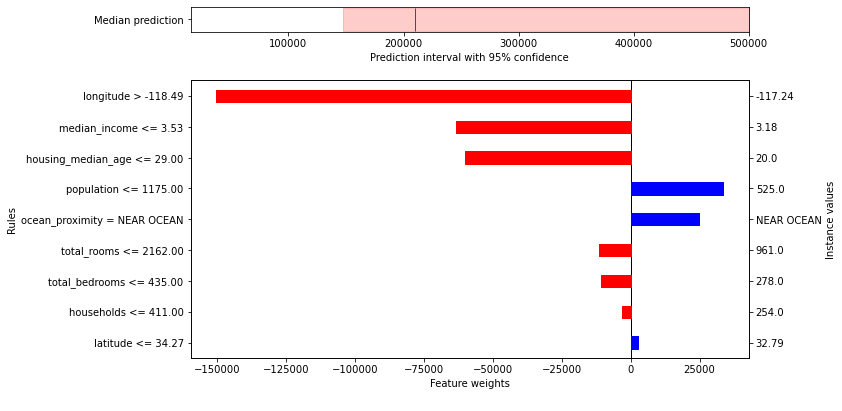

In [18]:
exp = ce(testX, low_high_percentiles=osli)
exp.plot_regular(n_features_to_show=10, save_ext=[])

#### One-sided upper-bounded interval with 95% confidence
Here `low_high_percentiles=osui` to get a one-sided upper-bounded interval.

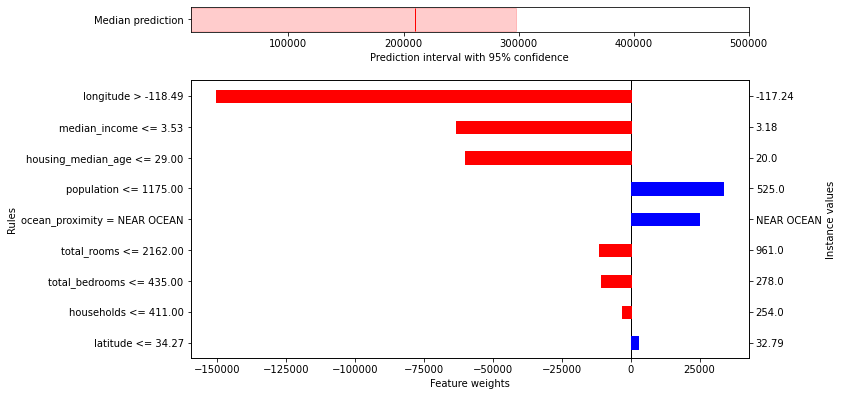

In [19]:
exp = ce(testX, low_high_percentiles=osui)
exp.plot_regular(n_features_to_show=10, save_ext=[])

#### Two-sided counterfactual rules 

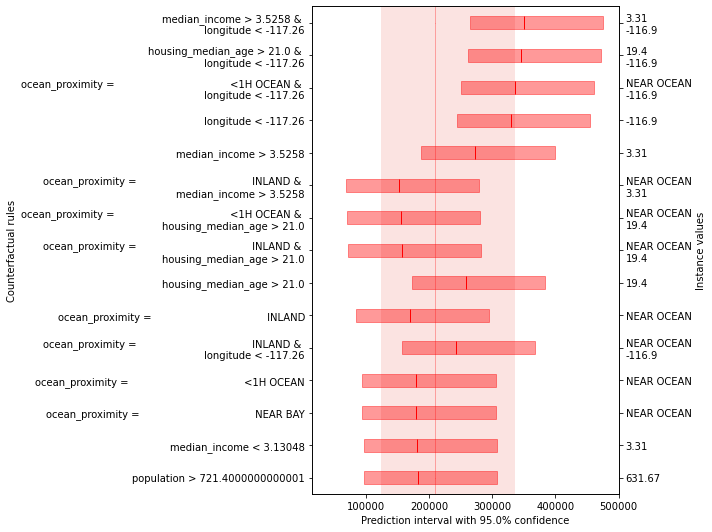

In [20]:
discretizer = 'decile'
ce.set_discretizer(discretizer)
exp = ce(testX, low_high_percentiles=tsi)
exp.add_conjunctive_counterfactual_rules(num_to_include=5).plot_counterfactuals(n_features_to_show=15, save_ext=[])

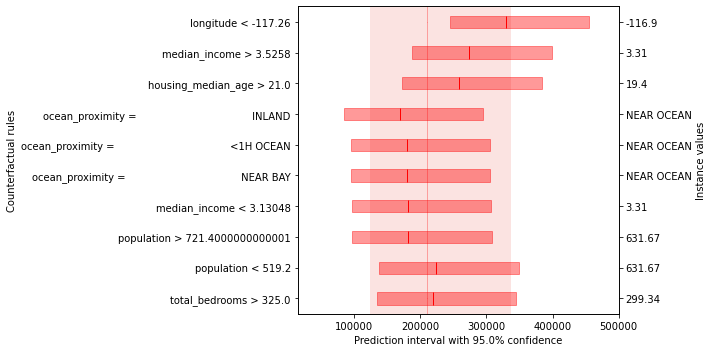

In [21]:
exp.remove_conjunctive_rules().plot_counterfactuals(n_features_to_show=10, save_ext=[])

#### One-sided counterfactual rules

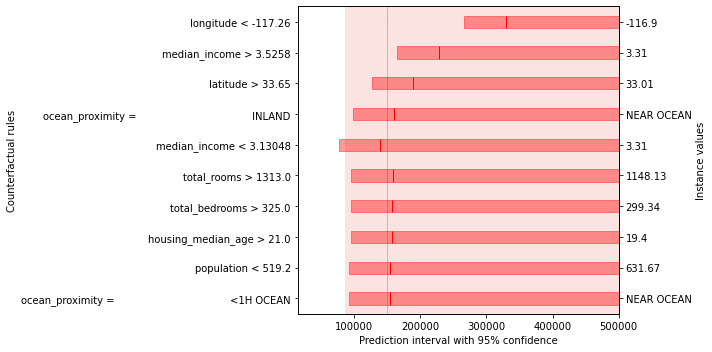

In [22]:
exp = ce(testX, low_high_percentiles=osli)
exp.plot_counterfactuals(n_features_to_show=10, save_ext=[])

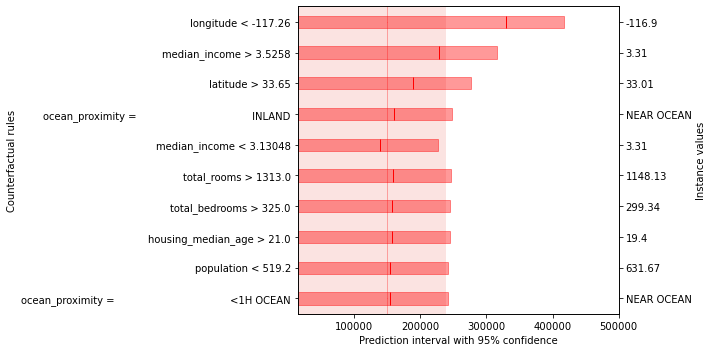

In [23]:
exp = ce(testX, low_high_percentiles=osui)
exp.plot_counterfactuals(n_features_to_show=10, save_ext=[])

#### Normalized explanations using knn

There are three ways to set the difficulty estimator (sigma) for the CalibratedExplainer when using k-nearest neighbor.
* alternative 1: by the (Euclidean) distances to the nearest neighbors
* alternative 2: by the standard deviation of the targets of the nearest neighbors
* alternative 3: by the absolute errors of the k nearest neighbors

See the documentation of crepes for further details on how the `DifficultyEstimator` works, see [here](https://crepes.readthedocs.io/en/latest/).

In [24]:
# alternative 1: by the (Euclidean) distances to the nearest neighbors
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, scaler=True))

# alternative 2: by the standard deviation of the targets of the nearest neighbors
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, y=trainY, scaler=True))

# alternative 3: by the absolute errors of the k nearest neighbors
oob_predictions = model.oob_prediction_ # requires the model to have been trained with oob_score=True, available for RandomForestRegressor
residuals_oob = trainY - oob_predictions
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, residuals=residuals_oob, scaler=True))

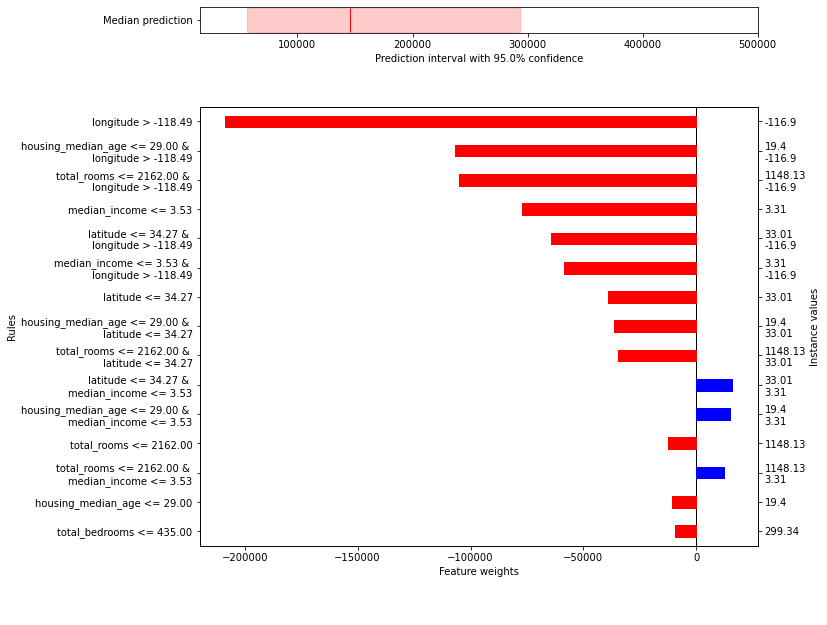

In [25]:
discretizer = 'binary'
ce.set_discretizer(discretizer)
exp = ce(testX, low_high_percentiles=tsi)
exp.add_conjunctive_factual_rules(num_to_include=5)
exp.plot_regular(n_features_to_show=15, save_ext=[])

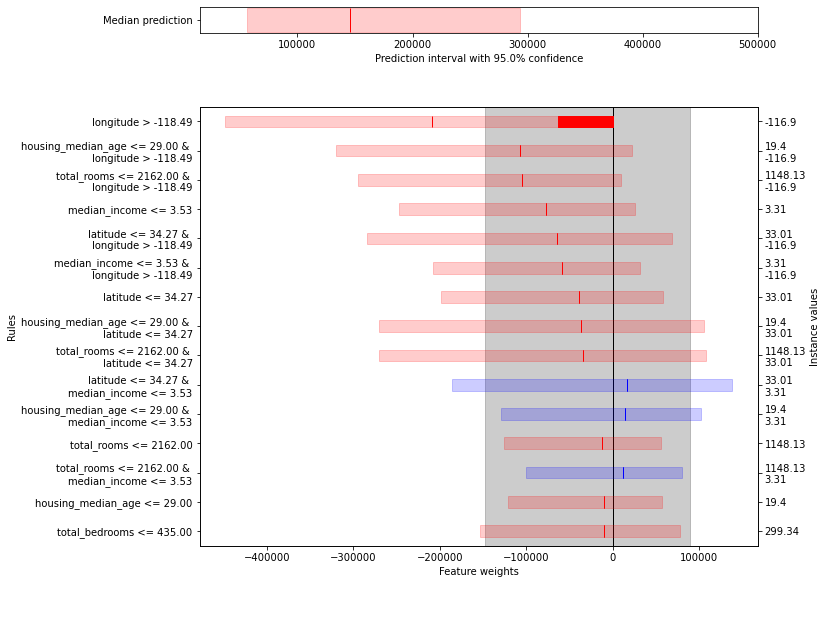

In [26]:
exp.plot_uncertainty(n_features_to_show=15, save_ext=[])

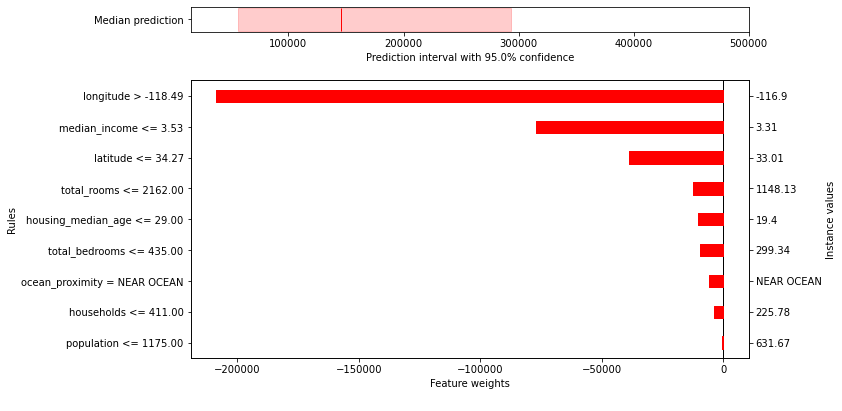

In [27]:
exp.remove_conjunctive_rules()
exp.plot_regular(n_features_to_show=10, save_ext=[])

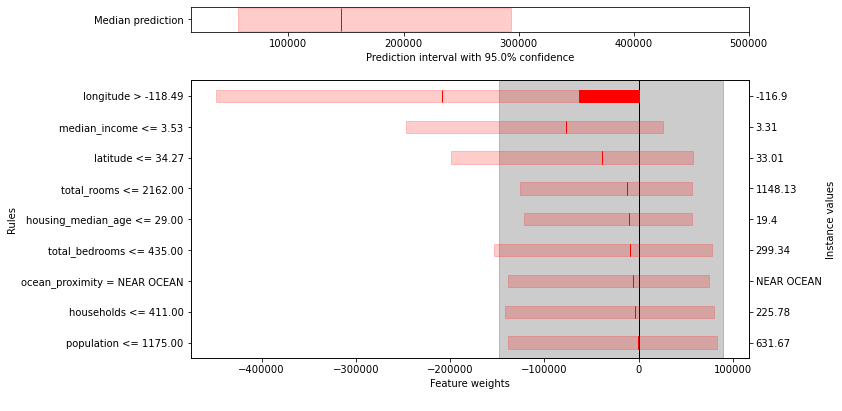

In [28]:
exp.plot_uncertainty(n_features_to_show=10, save_ext=[])

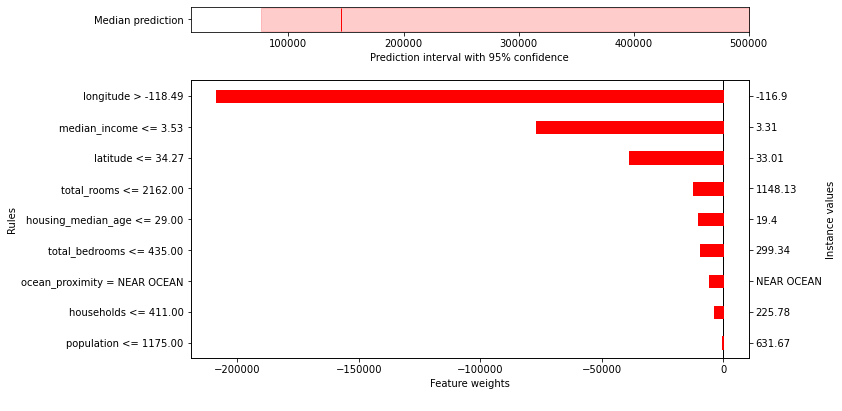

In [29]:
exp = ce(testX, low_high_percentiles=osli)
exp.plot_regular(n_features_to_show=10, save_ext=[])

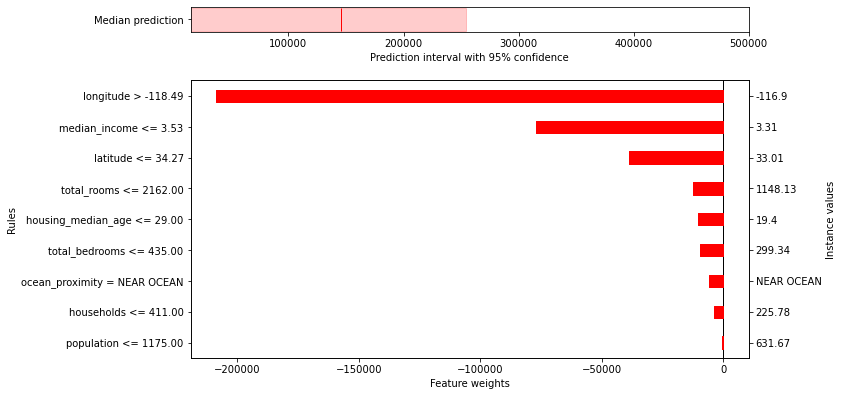

In [30]:
exp = ce(testX, low_high_percentiles=osui)
exp.plot_regular(n_features_to_show=10, save_ext=[])

#### Normalized counterfactuals using knn 

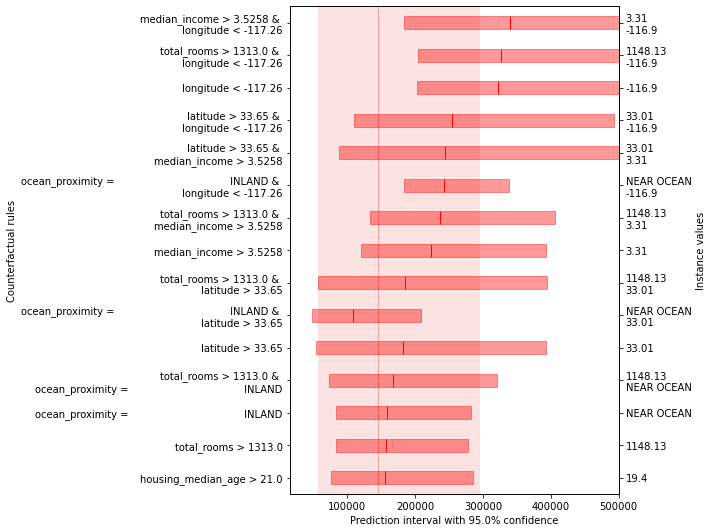

In [31]:
discretizer = 'decile'
ce.set_discretizer(discretizer)
exp = ce(testX, low_high_percentiles=tsi)
exp.add_conjunctive_counterfactual_rules(num_to_include=5).plot_counterfactuals(n_features_to_show=15, save_ext=[])


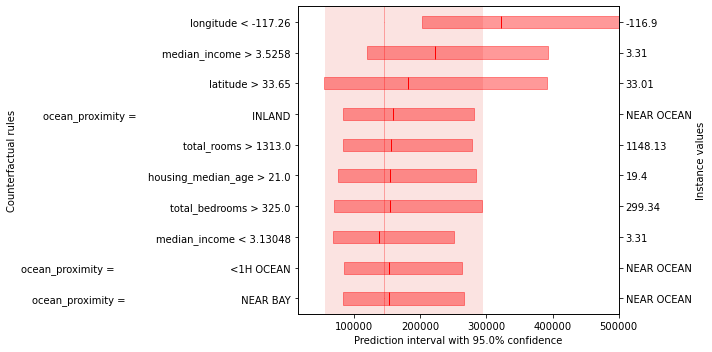

In [32]:
exp.remove_conjunctive_rules().plot_counterfactuals(n_features_to_show=10, save_ext=[])

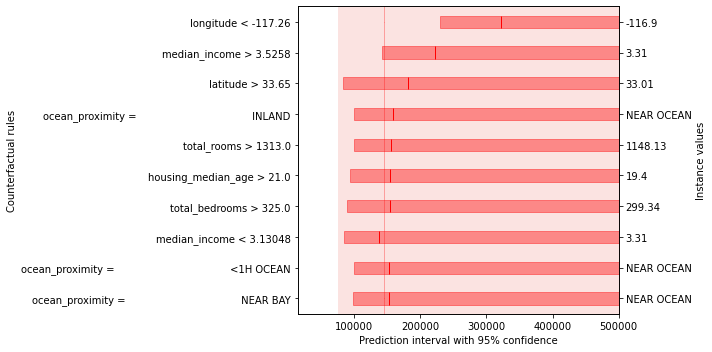

In [33]:
exp = ce(testX, low_high_percentiles=osli)
exp.plot_counterfactuals(n_features_to_show=10, save_ext=[])

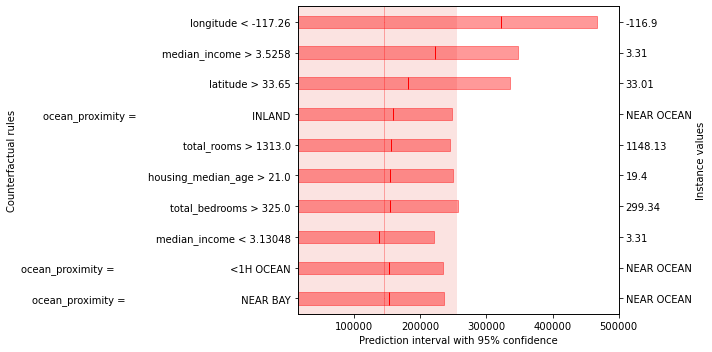

In [34]:
exp = ce(testX, low_high_percentiles=osui)
exp.plot_counterfactuals(n_features_to_show=10, save_ext=[])

#### Normalized explanations using variance

In [35]:
ce.set_difficulty_estimator(DifficultyEstimator().fit(X=trainX, learner=model, scaler=True))

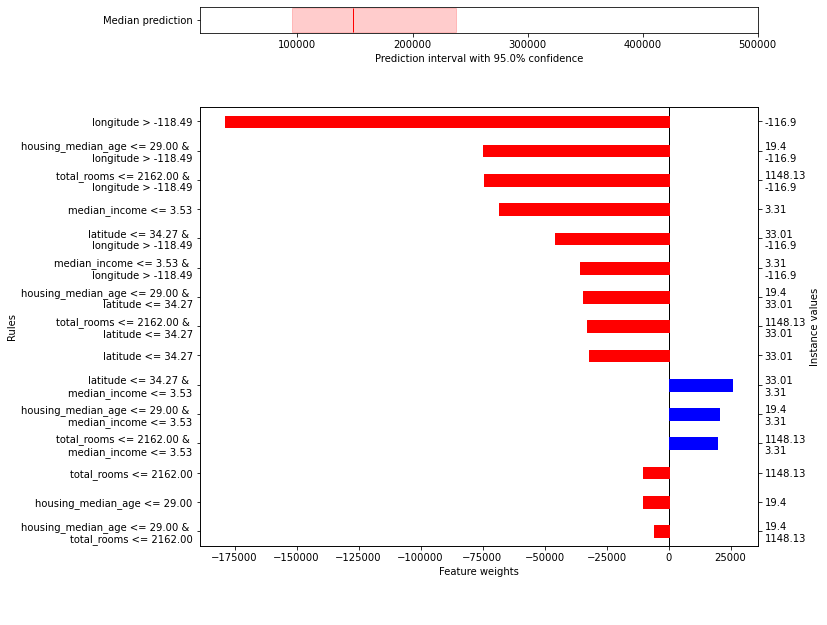

In [36]:
discretizer = 'binary'
ce.set_discretizer(discretizer)
exp = ce(testX, low_high_percentiles=tsi)
exp.add_conjunctive_factual_rules(num_to_include=5)
exp.plot_regular(n_features_to_show=15, save_ext=[])

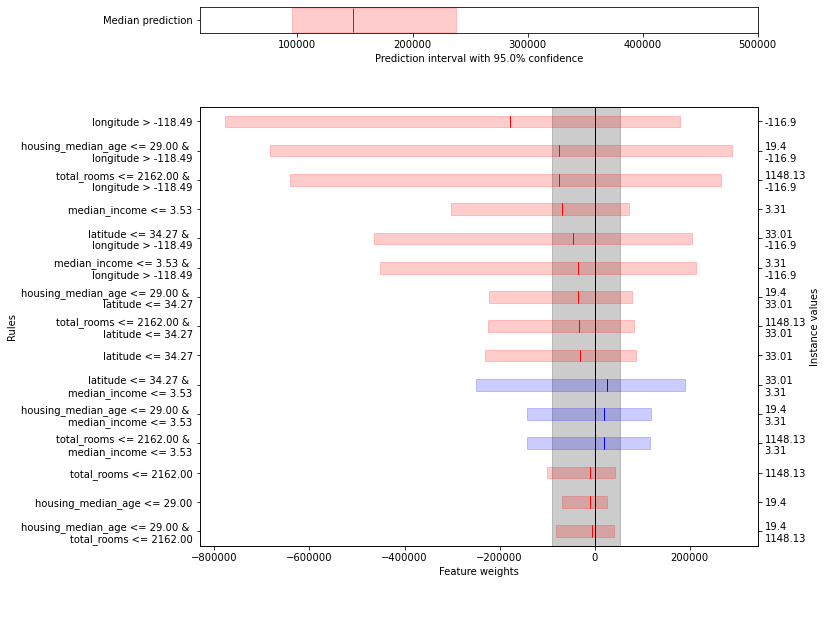

In [37]:
exp.plot_uncertainty(n_features_to_show=15, save_ext=[])

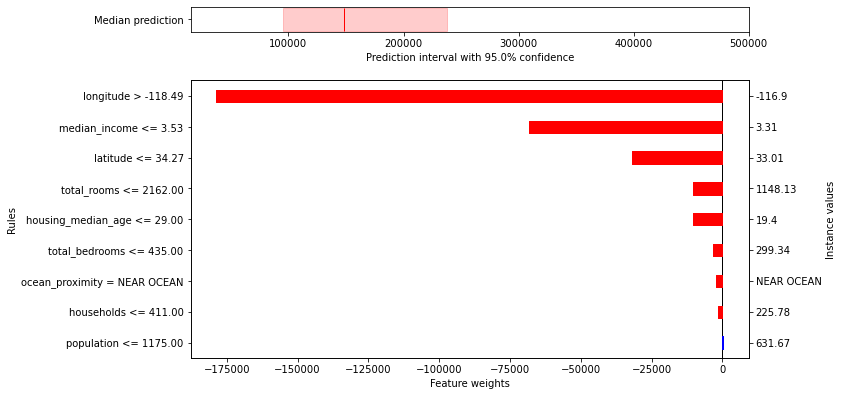

In [38]:
exp.remove_conjunctive_rules()
exp.plot_regular(n_features_to_show=10, save_ext=[])

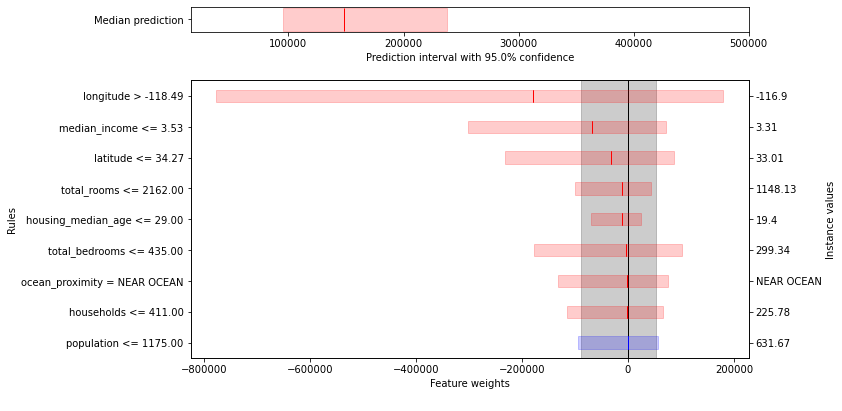

In [39]:
exp.plot_uncertainty(n_features_to_show=10, save_ext=[])

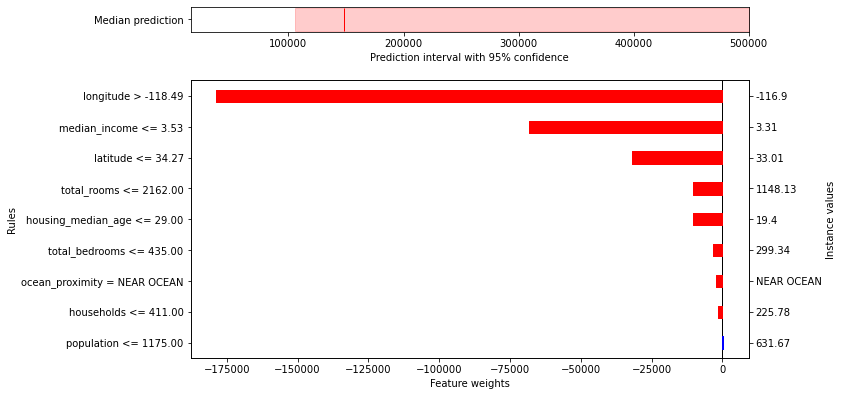

In [40]:
exp = ce(testX, low_high_percentiles=osli)
exp.plot_regular(n_features_to_show=10, save_ext=[])

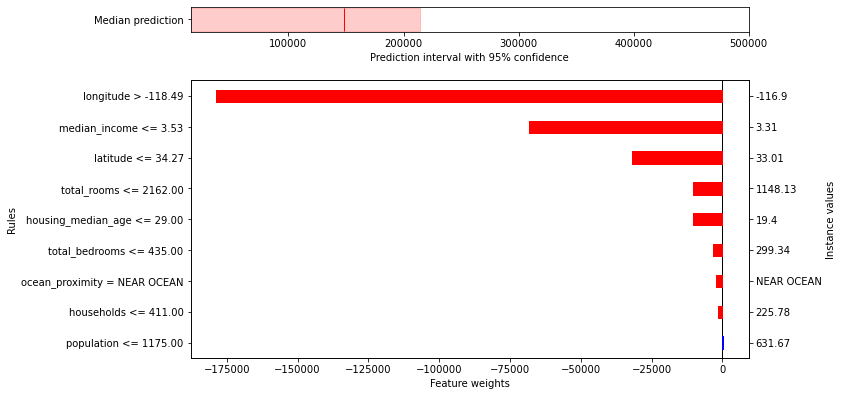

In [41]:
exp = ce(testX, low_high_percentiles=osui)
exp.plot_regular(n_features_to_show=10, save_ext=[])

#### Normalized counterfactuals using variance

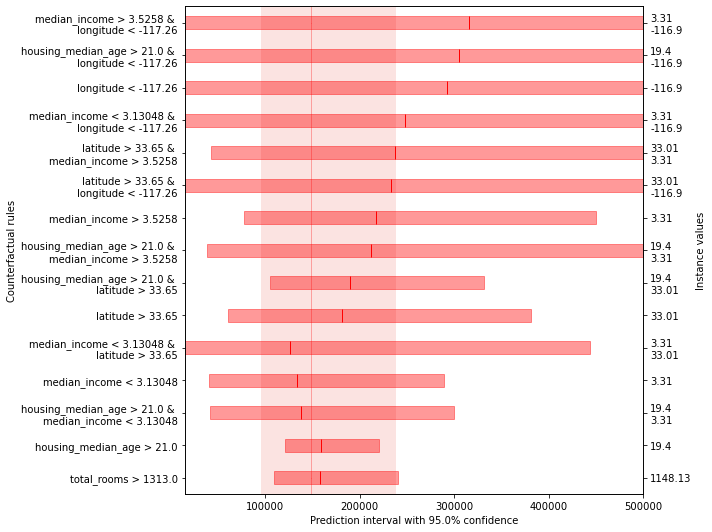

In [42]:
discretizer = 'decile'
ce.set_discretizer(discretizer)
exp = ce(testX, low_high_percentiles=tsi)
exp.add_conjunctive_counterfactual_rules(num_to_include=5).plot_counterfactuals(n_features_to_show=15, save_ext=[])

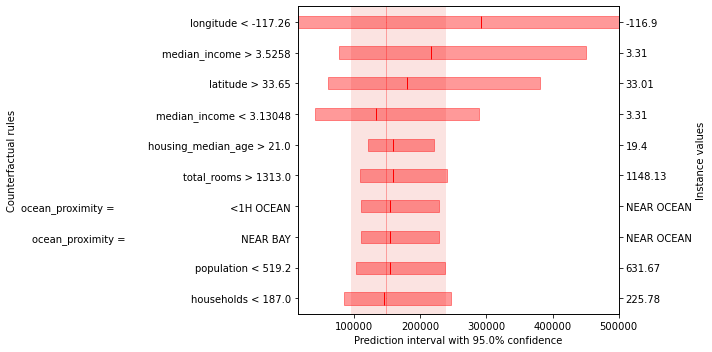

In [43]:
exp.remove_conjunctive_rules().plot_counterfactuals(n_features_to_show=10, save_ext=[])

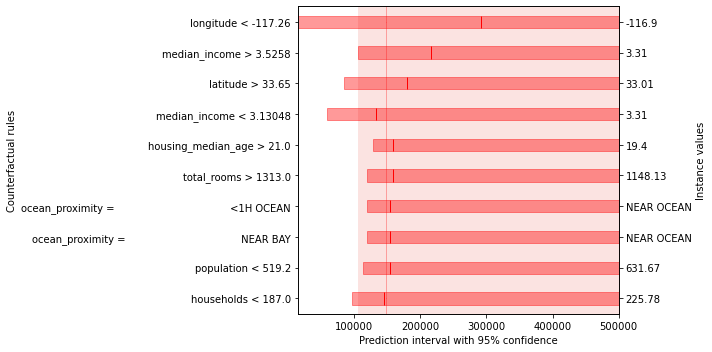

In [44]:
exp = ce(testX, low_high_percentiles=osli)
exp.plot_counterfactuals(n_features_to_show=10, save_ext=[])

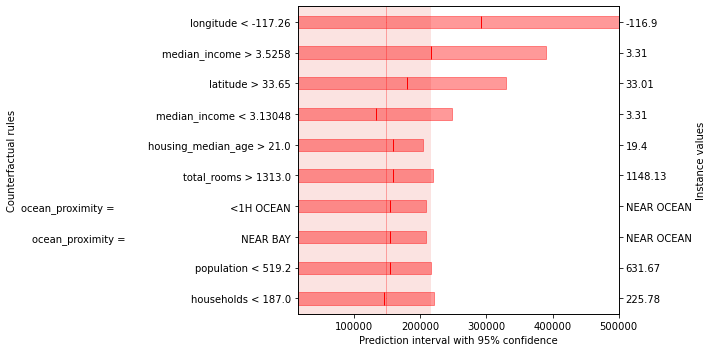

In [45]:
exp = ce(testX, low_high_percentiles=osui)
exp.plot_counterfactuals(n_features_to_show=10, save_ext=[])